# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns

from matplotlib import cm
from plotly import express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import RobustScaler, LabelEncoder

## Funções de suporte

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 16
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
jupyter_settings()

In [3]:
def data_summary(num_attributes):
    # Central tendency - mean, median
    tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    tc2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Variability - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(min)).T
    d2 = pd.DataFrame(num_attributes.apply(max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concatenate
    s = pd.concat([d1, d2, d3, tc1, tc2, d4, d5, d6]).T.reset_index()
    s.columns = ['columns', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return s

In [4]:
def eval_wss(x, clusters, random_state=73):
    wss = []
    for k in clusters:
        model = KMeans(init = 'random',
                       n_clusters = k,
                       max_iter = 300,
                       random_state = random_state)
        model.fit(x)
        wss.append(model.inertia_)
    return wss

def eval_ss(x, clusters, random_state=73):
    ss = []
    for k in clusters:
        model = KMeans(n_clusters=k, random_state=random_state)
        pred = model.fit_predict(x)
        score = silhouette_score(x, pred, metric='euclidean')
        ss.append(score)
    return ss

## Importar dados

In [5]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'latin1')
df_raw.drop('Unnamed: 8', axis = 1, inplace = True)

# 1 Descrição dos dados

In [6]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [7]:
cols = ['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

In [8]:
df1.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

**invoice:** Invoice number (A 6-digit integral number uniquely assigned to each transaction)

**stock_code:** Product (item) code

**description:** Product (item) name

**quantity:** The quantities of each product (item) per transaction

**invoice_date:** The day when each transaction was generated

**unit_price:** Unit price (Product price per unit)

**customer_id:** Customer number (Unique ID assigned to each customer)

**country:** Country name (The name of the country where each customer resides)

## 1.2 Dimensão dos dados

In [9]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de colunas: 8


## 1.3 Tratar os NAs

In [10]:
df1['description'].fillna('-', inplace = True)

In [11]:
# Criando id únicos para cada fatura não identificada
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[~df1['customer_id'].isna()]

# Criar referência com base no número do invoice
df_ref = pd.DataFrame(df_missing['invoice'].drop_duplicates())
df_ref['customer_id'] = np.arange(19000, 19000+len(df_ref), 1)

# Juntar referência com dataframe original
df1 = df1.merge(df_ref, how = 'left', on = 'invoice')

# Coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Drop extra id columns
df1.drop(columns = ['customer_id_x', 'customer_id_y'], inplace = True)

In [12]:
df1.isna().sum()

invoice         0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 1.4 Tipo dos dados

In [13]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')
df1['customer_id'] = df1['customer_id'].astype(int)

In [14]:
df1.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.5 Estatística descritiva

In [15]:
num_attributes = df1[['quantity', 'unit_price']]
cat_attributes = df1[['invoice', 'stock_code', 'description', 'customer_id', 'country']]

### 1.5.1 Atributos numéricos

In [16]:
data_summary(num_attributes)

,columns,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097


### 1.5.2 Atributos categóricos

In [17]:
cat_attributes.apply(lambda x: x.nunique())

invoice        25900
stock_code      4070
description     4224
customer_id     8082
country           38
dtype: int64

In [18]:
df1[df1['stock_code'].apply(
    lambda x: bool(re.search('^[a-zA-Z]+$', x)))
   ]['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# 2 Filtragem das variáveis

## Data checkpoint

In [19]:
df2 = df1.copy()

In [20]:
df2.to_csv('../data/interim/c3_df2.csv', index = False)

In [21]:
df2 = pd.read_csv('../data/interim/c3_df2.csv')
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])

## 2.1 Stock code

In [21]:
size_of_data = len(df2)

In [22]:
df2.loc[df2['stock_code'].apply(lambda x: x.isalpha()), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [23]:
# Remover stock code M, POST, PADS, DOT, CRUK
bad_code = ['M', 'POST', 'PADS', 'DOT', 'CRUK']
bad_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin(bad_code)]

## 2.2 Quantity & price

In [24]:
# Remover quantidades negativas dos clientes não identificados
df2 = df2.drop(df2[(df2['quantity'] < 0) & (df2['customer_id'] >= 19000)].index)

In [25]:
# Remover itens com preço zero
df2 = df2[df2['unit_price'] > 0]

## 2.3 Description

In [26]:
df2.loc[df2['description'].apply(lambda x: x.isalpha()), 'description'].unique()

array(['CARRIAGE'], dtype=object)

In [27]:
# Remover description CARRIAGE
df2 = df2[df2['description'] != 'CARRIAGE']

## 2.4 Customer id

In [28]:
# Clientes cujos id só possuem mais registros de devolução do que compra.
bad_customers = [12605, 12666, 12870, 12943, 13693, 
                 13829, 13958, 14119, 14213, 14627, 
                 14679, 14777, 15638, 15728, 16061, 
                 16138, 16252, 16262, 16428, 16579, 
                 16742, 16995, 17307, 17547, 17820, 
                 18141, 18256, 15823, 17548, 16546]
df2 = df2[~df2['customer_id'].isin(bad_customers)]

## 2.5 Dados filtrados

In [29]:
print('Dados removidos: {:.1f}%'.format(100*(1-df2.shape[0]/size_of_data)))
print('Número de linhas: {}'.format(df2.shape[0]))

Dados removidos: 1.1%
Número de linhas: 536168


# 3 Feature engineering

## Data checkpoint

In [30]:
df3 = df2.copy()

In [31]:
df3.to_csv('../data/interim/c3_df3.csv', index = False)

In [13]:
df3 = pd.read_csv('../data/interim/c3_df3.csv')
df3['invoice_date'] = pd.to_datetime(df3['invoice_date'])

## 3.1 Criação das variáveis

*Customer*

**customer_id:** customer identification

**country:** customer's country of residence

**vintage:** how many months customer is client

*Revenue*

**revenue:** total amount spend by customer so far

**return:** total value of charge back invoices

**avg_ticket:** average expense of a customer per invoice

**low_purch:** lowest purchase value

**high_purch:** highest purchase value

**monthly_revenue:** monthly expense of a customer

*Frequency*

**invoices:** number of purchases

**monthly_invoices:** number of purchases (invoices) per month

**invoices_return:** number of returns

*Recency*

**recency:** time since last purchase

**mean_recency:** average interval between purchases

*Habits*

**mean_basket_size:** average number of items per purchase

**product_variety:** number of unique products

**low_unit_price:** smallest price of a single product purchased

**high_unit_price:** highest price of a single product purchased

**avg_unit_price:** average price of the products purchased

In [14]:
purchases = df3[~df3['invoice'].str.startswith('C')]
charge_back = df3[df3['invoice'].str.startswith('C')]

In [15]:
# Revenue
purchases['price'] = purchases['quantity']*purchases['unit_price']
charge_back['price'] = charge_back['quantity']*charge_back['unit_price']
df_customer = purchases[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'revenue'})

# Return
aux = charge_back[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'return'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['return'].fillna(0, inplace = True)

# Invoices - number of purchases
aux = purchases[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'invoices'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Invoices return
aux = charge_back[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'invoices_return'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['invoices_return'].fillna(0, inplace = True)

# Last invoice date
aux = purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index().rename(columns = {'invoice_date': 'last_date'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Recency - days since last purchase
ref_date = df_customer['last_date'].max()
df_customer['recency'] = df_customer['last_date'].apply(lambda x: (ref_date-x).days)

# Average recency
aux = purchases[['customer_id', 'invoice_date']].groupby('customer_id').min().reset_index().rename(columns = {'invoice_date': 'first_purch'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['avg_recency'] = df_customer.apply(lambda x: (ref_date-x['first_purch']).days/x['invoices'], axis = 1)

# Average ticket
df_purch = purchases[['customer_id', 'invoice', 'price', 'quantity']].groupby(['customer_id', 'invoice']).sum().reset_index()
df_customer['avg_ticket'] = df_purch.groupby('customer_id').mean().reset_index()['price']

# Low purch
df_customer['low_purch'] = df_purch.groupby('customer_id').min().reset_index()['price']

# High purch
df_customer['high_purch'] = df_purch.groupby('customer_id').max().reset_index()['price']

# Mean basket size
df_customer['basket_size'] = df_purch.groupby('customer_id').mean().reset_index()['quantity']

# Country
customers = purchases['customer_id'].unique()
country = []
for customer in customers:
    aux = purchases.loc[purchases['customer_id'] == customer]
    last_date = aux['invoice_date'].max()
    country.append(aux[aux['invoice_date'] == last_date]['country'].iloc[0])
df_country = pd.DataFrame({'customer_id': customers, 'country': country})
df_customer = df_customer.merge(df_country, how = 'left', on = 'customer_id')

C:\Users\Adm\AppData\Local\Temp/ipykernel_51496/2547821566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['price'] = purchases['quantity']*purchases['unit_price']
C:\Users\Adm\AppData\Local\Temp/ipykernel_51496/2547821566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charge_back['price'] = charge_back['quantity']*charge_back['unit_price']


In [16]:
# Low unit price
auxgroup = df3[['customer_id', 'unit_price']].groupby('customer_id')
aux = auxgroup.min().reset_index().rename(columns = {'unit_price': 'low_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# High unit price
aux = auxgroup.max().reset_index().rename(columns = {'unit_price': 'high_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Avg unit price
aux = auxgroup.mean().reset_index().rename(columns = {'unit_price': 'avg_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Product variety
aux = df3[['customer_id', 'stock_code']].groupby('customer_id').nunique().reset_index().rename(columns = {'stock_code': 'product_variety'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Monthly invoices
df_customer['vintage'] = df_customer.apply(lambda x: (ref_date-x['first_purch']).days/30, axis = 1)
df_customer['monthly_invoices'] = df_customer.apply(lambda x: x['invoices'] if x['vintage'] == 0 
                                                    else x['invoices']/x['vintage'], axis = 1)

# Monthly revenue
df_customer['monthly_revenue'] = df_customer.apply(lambda x: x['revenue'] if x['vintage'] == 0 
                                                    else x['revenue']/x['vintage'], axis = 1)

In [17]:
df_customer.isna().sum()

customer_id         0
revenue             0
return              0
invoices            0
invoices_return     0
last_date           0
recency             0
first_purch         0
avg_recency         0
avg_ticket          0
low_purch           0
high_purch          0
basket_size         0
country             0
low_unit_price      0
high_unit_price     0
avg_unit_price      0
product_variety     0
vintage             0
monthly_invoices    0
monthly_revenue     0
dtype: int64

In [21]:
df3 = df_customer.drop(columns = ['last_date', 'first_purch']).copy()

# 4 Análise exploratória de dados

## Data checkpoint

In [22]:
df4 = df3.copy()

In [25]:
df4.to_csv('../data/interim/c3_df4.csv', index = False)

In [31]:
df4 = pd.read_csv('../data/interim/c3_df4.csv')

## 4.1 Análise univariada

### 4.1.1 Variáveis numéricas

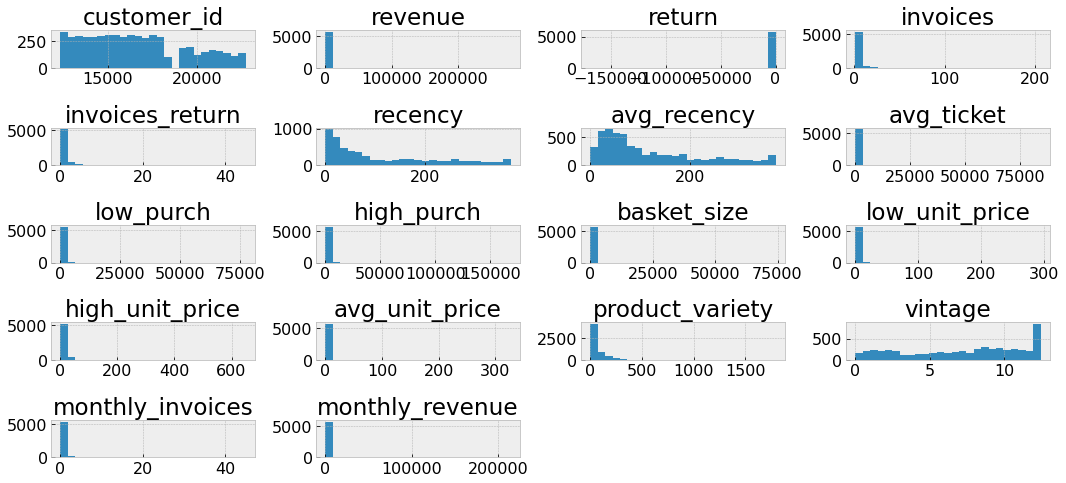

In [32]:
df4.hist(bins = 25);
plt.tight_layout()

### 4.1.2 Variáveis categóricas

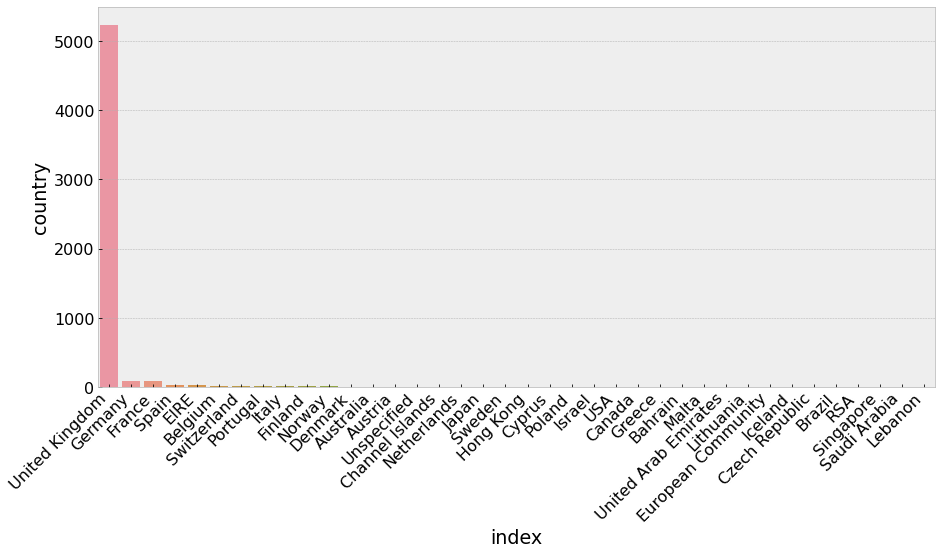

In [29]:
aux = df4['country'].value_counts().reset_index()
sns.barplot(data = aux, x = 'index', y = 'country')
plt.xticks(rotation = 45, horizontalalignment = 'right');

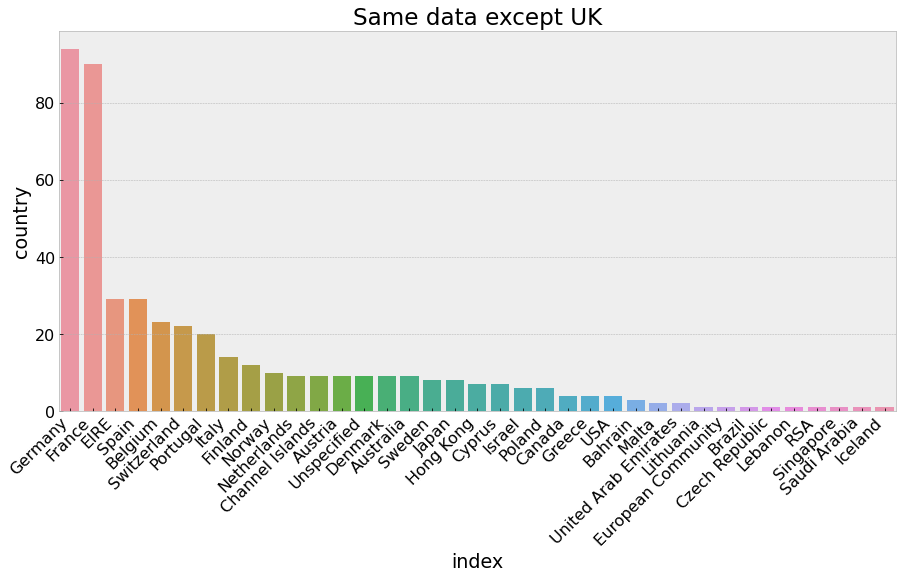

In [30]:
aux = df4[df4['country'] != 'United Kingdom']['country'].value_counts().reset_index()
sns.barplot(data = aux, x = 'index', y = 'country')
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.title('Same data except UK');

In [13]:
df4['country'].value_counts(normalize = True)

United Kingdom          0.903531
Germany                 0.021694
France                  0.020078
Spain                   0.006693
Belgium                 0.005308
Portugal                0.004385
Switzerland             0.004385
Italy                   0.003231
Finland                 0.002769
Norway                  0.002308
Netherlands             0.002077
Austria                 0.002077
Channel Islands         0.002077
Denmark                 0.002077
Australia               0.002077
Sweden                  0.001846
Japan                   0.001846
Cyprus                  0.001616
Poland                  0.001385
USA                     0.000923
Canada                  0.000923
Greece                  0.000923
Unspecified             0.000923
Israel                  0.000692
EIRE                    0.000692
United Arab Emirates    0.000462
Bahrain                 0.000462
Malta                   0.000462
Saudi Arabia            0.000231
Singapore               0.000231
Iceland   

# 5 Preparação dos dados

## Data checkpoint

In [33]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [34]:
rs = RobustScaler()

# revenue
df5['revenue'] = rs.fit_transform(df5[['revenue']].values)
pickle.dump(rs, open('../src/features/revenue_scaler.pkl', 'wb'))

# return
df5['return'] = rs.fit_transform(df5[['return']].values)
pickle.dump(rs, open('../src/features/return_scaler.pkl', 'wb'))

# invoices
df5['invoices'] = rs.fit_transform(df5[['invoices']].values)
pickle.dump(rs, open('../src/features/invoices_scaler.pkl', 'wb'))

# recency
df5['recency'] = rs.fit_transform(df5[['recency']].values)
pickle.dump(rs, open('../src/features/recency_scaler.pkl', 'wb'))

# mean_recency
df5['mean_recency'] = rs.fit_transform(df5[['mean_recency']].values)
pickle.dump(rs, open('../src/features/mean_recency_scaler.pkl', 'wb'))

# mean_ticket
df5['mean_ticket'] = rs.fit_transform(df5[['mean_ticket']].values)
pickle.dump(rs, open('../src/features/mean_ticket_scaler.pkl', 'wb'))

# low_purch
df5['low_purch'] = rs.fit_transform(df5[['low_purch']].values)
pickle.dump(rs, open('../src/features/low_purch_scaler.pkl', 'wb'))

# high_purch
df5['high_purch'] = rs.fit_transform(df5[['high_purch']].values)
pickle.dump(rs, open('../src/features/high_purch_scaler.pkl', 'wb'))

# basket_size
df5['basket_size'] = rs.fit_transform(df5[['basket_size']].values)
pickle.dump(rs, open('../src/features/basket_size_scaler.pkl', 'wb'))

KeyError: "None of [Index(['mean_recency'], dtype='object')] are in the [columns]"

## 5.3 Transformação

In [91]:
# country - label encoding
le = LabelEncoder()
df5['country'] = le.fit_transform(df5['country'])
pickle.dump(le, open('../src/features/country_encoder.pkl', 'wb'))

# 6 Seleção das features

In [92]:
df6 = df5.copy()

# 7 Ajuste fino dos hyperparâmetros

## Data checkpoint

In [93]:
df7 = df6.copy()
X = df7.drop('customer_id', axis = 1)

In [33]:
df7.to_csv('../data/interim/c2_df7.csv', index = False)

In [35]:
df7 = pd.read_csv('../data/interim/c1_df7.csv')
X = df7.drop('customer_id', axis = 1)

## 7.1 Within-Cluster Sum of Square

In [94]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

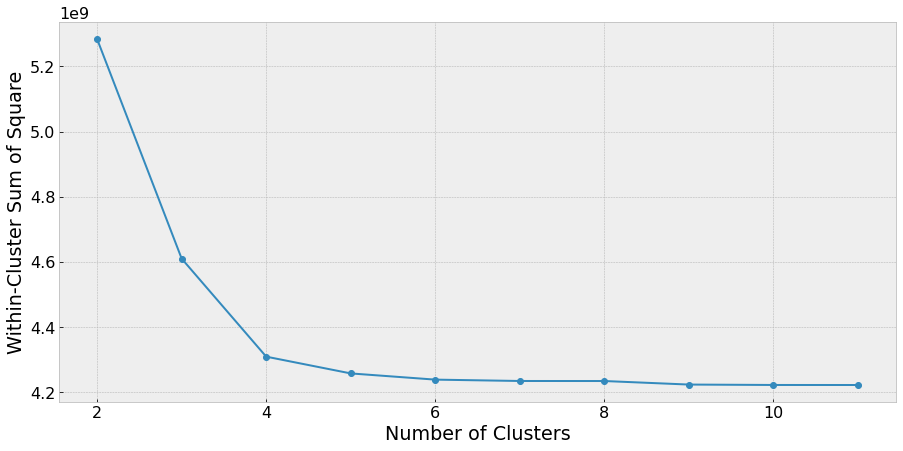

In [95]:
wss = eval_wss(X, clusters)
plt.plot(clusters, wss, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Square');

## 7.2 Silhouette Score

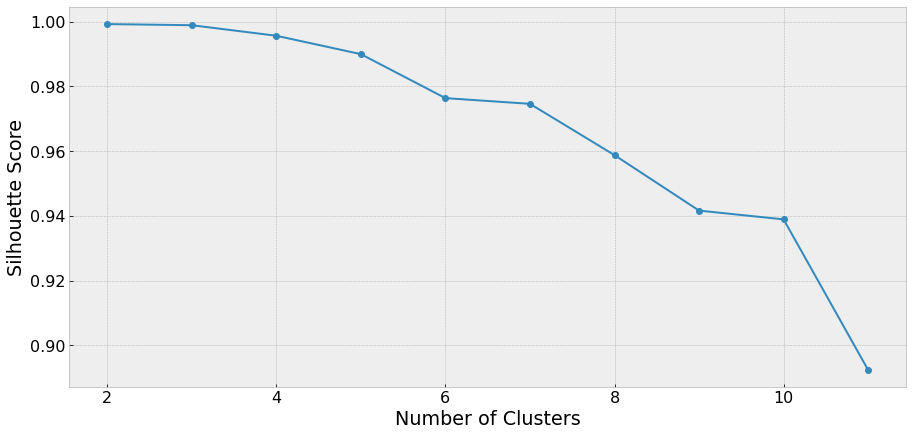

In [96]:
ss = eval_ss(X, clusters)
plt.plot(clusters, ss, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

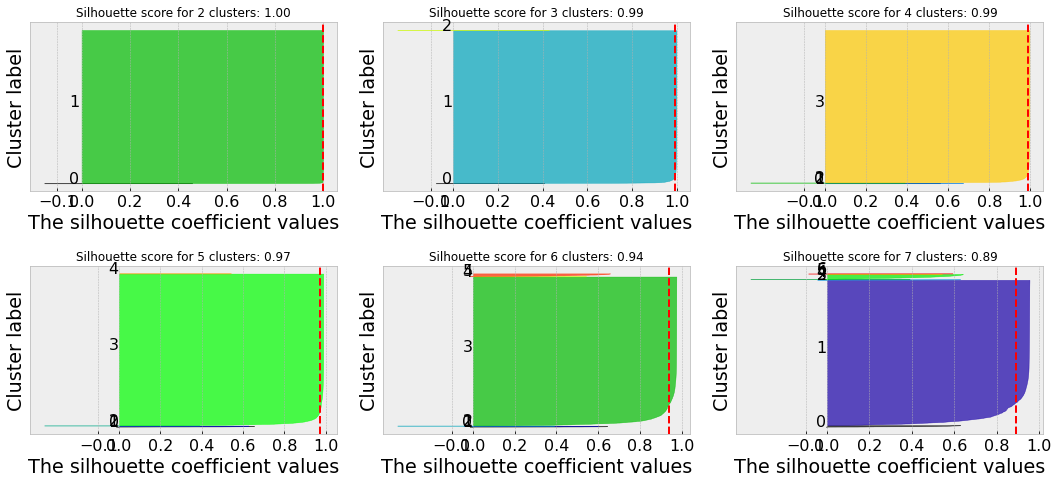

In [97]:
clusters = [2, 3, 4, 5, 6, 7]
grid_cols = 3
fig, axs = plt.subplots(2, grid_cols)
for i in range(len(clusters)):
    n_clusters = clusters[i]
    
    clusterer = KMeans(n_clusters=n_clusters, init='random', n_init=10, max_iter=100, random_state=73)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    r, c = divmod(i, grid_cols)
    for j in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster j, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / n_clusters)
        axs[r][c].fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          jth_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axs[r][c].text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axs[r][c].set_xlabel("The silhouette coefficient values")
    axs[r][c].set_ylabel("Cluster label")
    axs[r][c].set_title(
        'Silhouette score for {} clusters: {:.2f}'.format(n_clusters, silhouette_avg),
        fontsize = 12
    )

    # The vertical line for average silhouette score of all the values
    axs[r][c].axvline(x=silhouette_avg, color="red", linestyle="--")

    axs[r][c].set_yticks([]) # Clear the yaxis labels / ticks
    axs[r][c].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

fig.tight_layout()

# 8 Machine learning

## Data checkpoint

In [98]:
df8 = df7.copy()
X = df8.drop('customer_id', axis = 1)

## 8.1 K-means

In [99]:
n_clusters = 4

In [100]:
# Training
kmeans = KMeans(init = 'random',
                n_clusters = n_clusters,
                n_init = 10,
                max_iter = 300,
                random_state = 73)
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

### 8.1.1 Cluster validation

In [101]:
print('WSS: {}'.format(kmeans.inertia_))
print('SS: {}'.format(silhouette_score(X, labels, metric='euclidean')))

WSS: 4309361463.21175
SS: 0.9899865205127617


# 9 Análise do cluster

In [102]:
df9 = df7.copy()
df9['cluster'] = labels

## 9.1 Inspeção visual

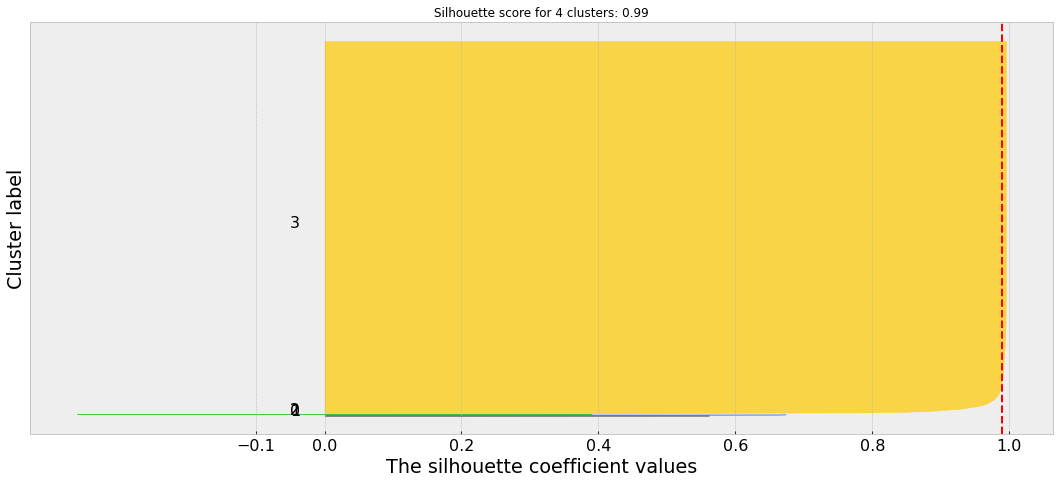

In [103]:
fig, ax = plt.subplots()

cluster_labels = kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
r, c = divmod(i, grid_cols)
for j in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster j, and sort them
    jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

    jth_cluster_silhouette_values.sort()

    size_cluster_j = jth_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_j

    color = cm.nipy_spectral(float(j) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0,
                      jth_cluster_silhouette_values,
                      facecolor=color,
                      edgecolor=color,
                      alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_title(
    'Silhouette score for {} clusters: {:.2f}'.format(n_clusters, silhouette_avg),
    fontsize = 12
)

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([]) # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

fig.tight_layout()

### 9.1.1 3 features

fig = px.scatter_3d(df9, x = 'recency', y = 'invoices', z = 'revenue', color = 'cluster')
fig.show()

### 9.1.2 More than 3 features

In [104]:
df_plot = df9.drop(columns = 'customer_id')

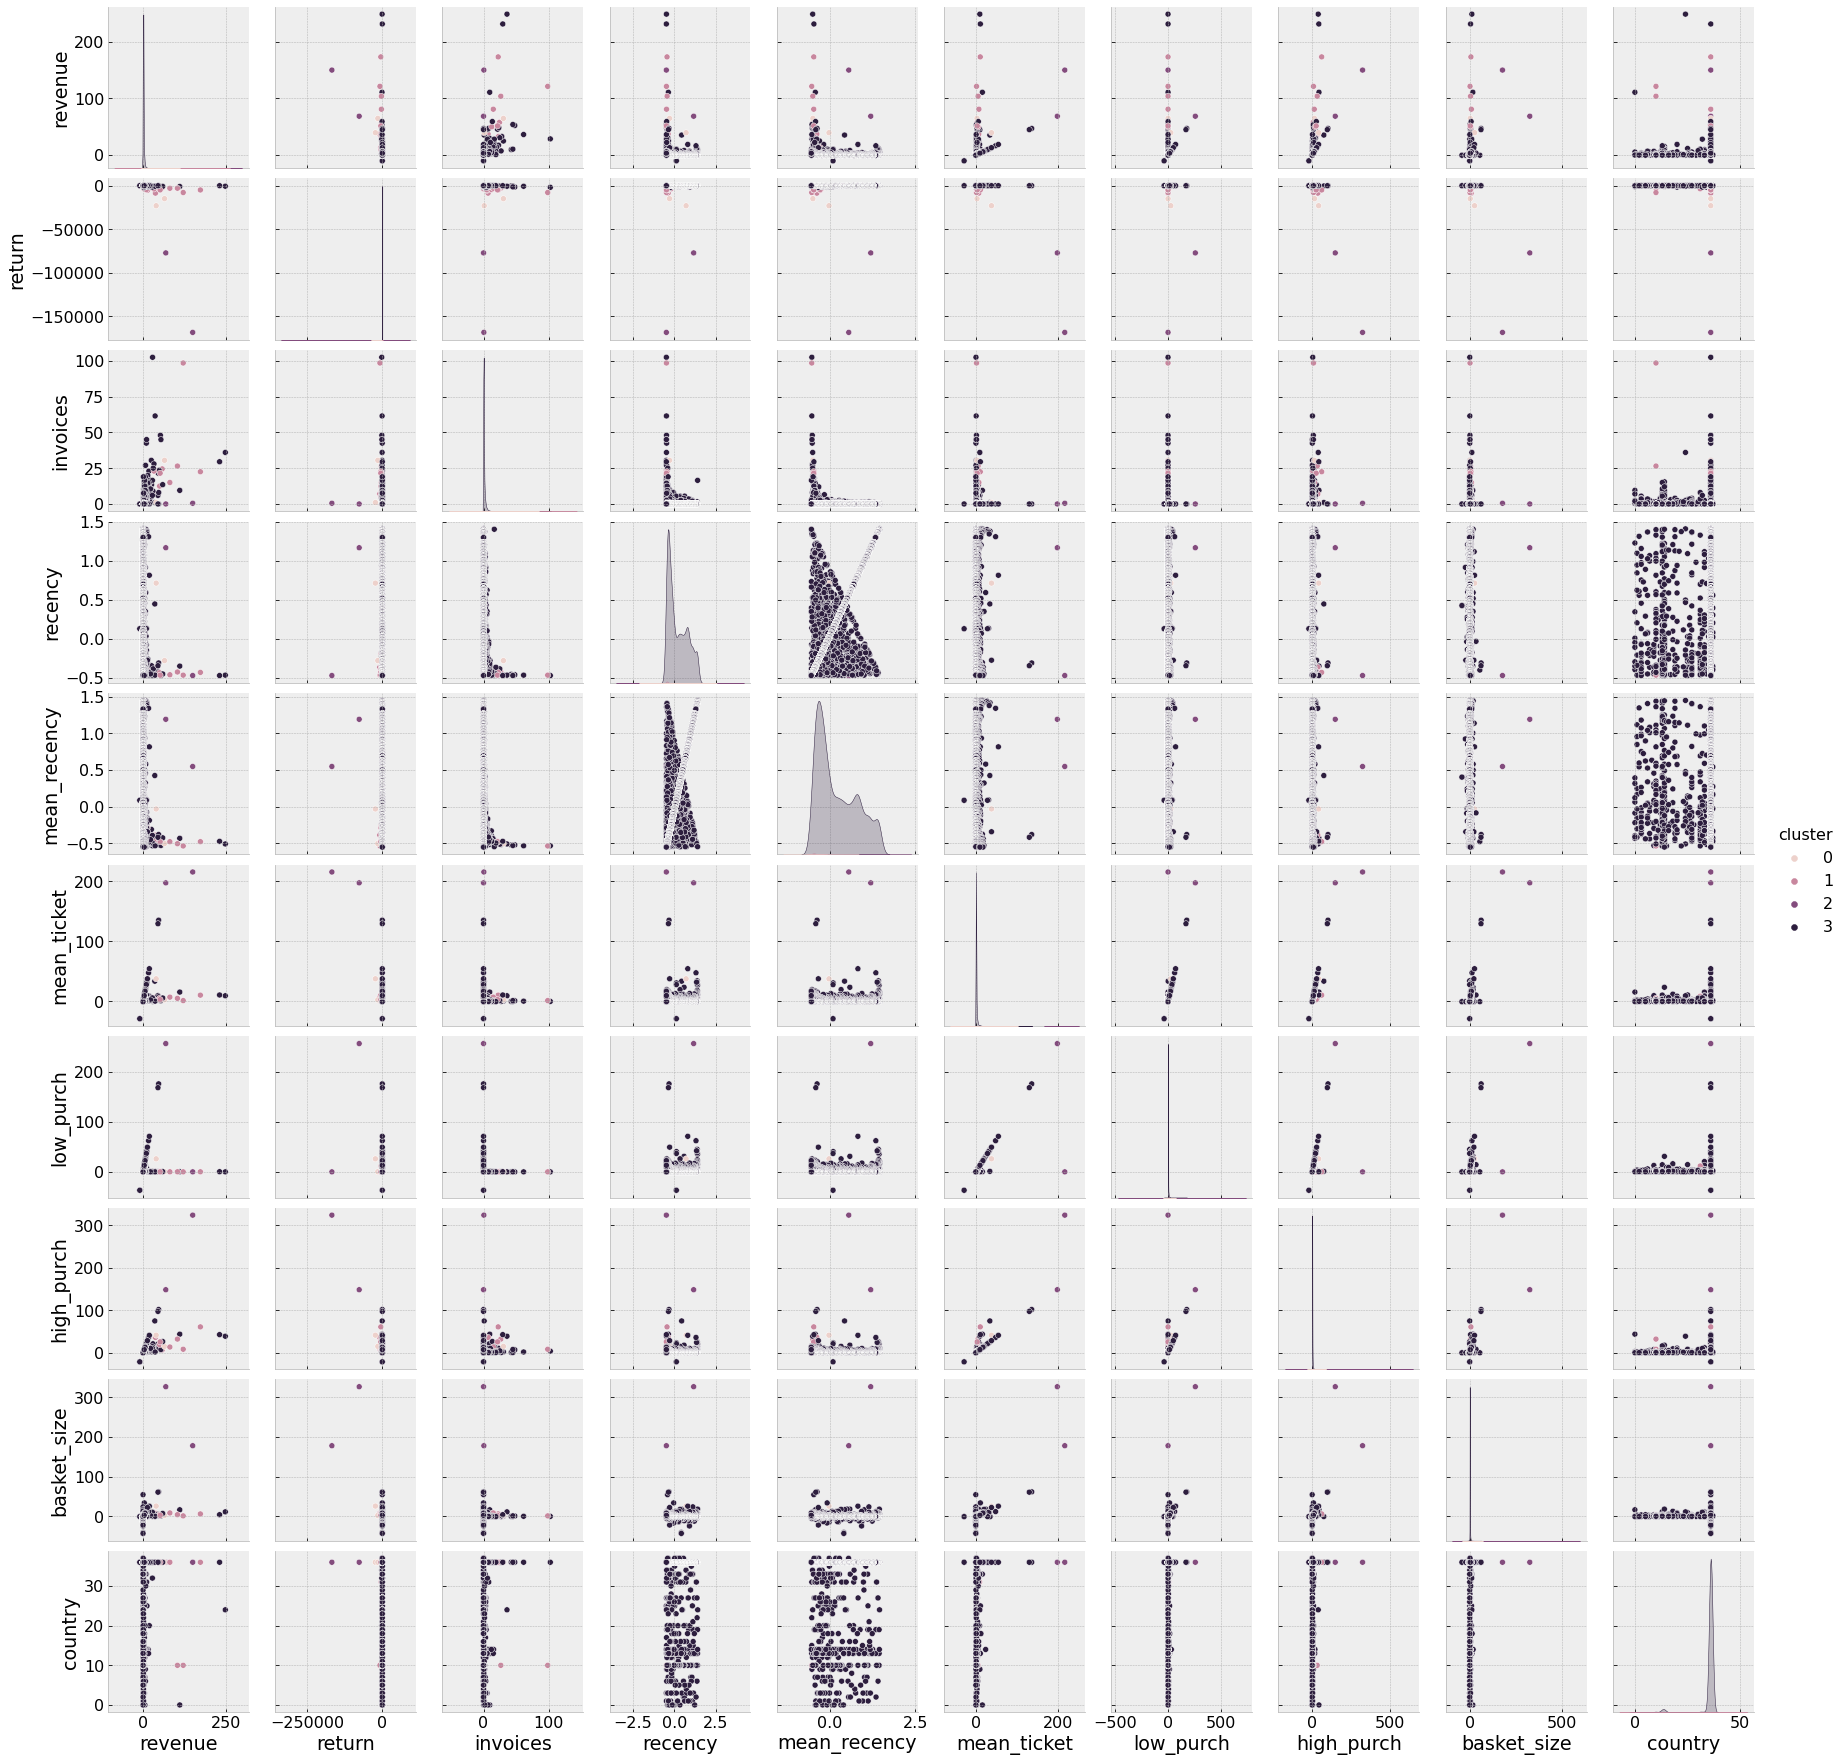

In [105]:
sns.pairplot(df_plot, hue = 'cluster')

## 9.2 Descrição do perfil

In [106]:
# Número de clientes
df_cluster = df9[['cluster', 'customer_id']].groupby('cluster').count().reset_index()
df_cluster['customer%'] = 100*df_cluster['customer_id']/df_cluster['customer_id'].sum()

# Receita média
aux = df9[['cluster', 'revenue']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Recência média
aux = df9[['cluster', 'recency']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Número de compras médio
aux = df9[['cluster', 'invoices']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Média do ticket médio
aux = df9[['cluster', 'mean_ticket']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

df_cluster

,cluster,customer_id,customer%,revenue,recency,invoices,mean_ticket
0,0,2,0.025598,52.024781,0.214646,15.750000,20.025128
1,1,13,0.166389,57.560468,-0.417249,20.807692,4.453615
2,2,2,0.025598,109.151727,0.345960,0.250000,206.200914
3,3,7796,99.782414,0.755503,0.193102,0.864161,0.536149


*Cluster 0:*
- Número de clientes: 31 (0,71% da base de clientes)
- Recência média: 13 dias
- Número médio de compras: 53 compras
- Receita média: $40.543,52

*Cluster 1 (candidato ao programa Insider):*
- Número de clientes: 6 (0,14% da base de clientes)
- Recência média: 7 dias
- Número médio de compras: 89 compras
- Receita média: $182.181,98

*Cluster 2:*
- Número de clientes: 4334 (99,15% da base de clientes)
- Recência média: 92 dias
- Número médio de compras: 4 compras
- Receita média: $1.372,89

In [113]:
df9[df9['cluster'] == 3]['customer_id'].max()

22709